In [0]:
from zipfile import ZipFile

In [2]:
import os
!pip install mxnet
import mxnet as mx
from mxnet import nd, autograd, gluon, ndarray
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
import sys
import cv2
from datetime import datetime
from sklearn.model_selection import train_test_split
from __future__ import print_function

In [3]:
mx.random.seed(1)
ctx = mx.cpu()
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class DataLoader(object):
    def __init__(self):
        DIR = '../MyDrive/data/'
        pass
   
    # Returns images and labels corresponding for training and testing. Default mode is train.
    # For retrieving test data pass mode as 'test' in function call.
    def load_data(self, mode = 'train'):
        label_filename = mode + '_labels'
        image_filename = mode + '_images'
        label_zip = '/content/drive/My Drive/data/' + label_filename + '.zip'
        image_zip = '/content/drive/My Drive/data/' + image_filename + '.zip'
        with ZipFile(label_zip, 'r') as lblzip:
            labels = np.frombuffer(lblzip.read(label_filename), dtype=np.uint8, offset=8)
        with ZipFile(image_zip, 'r') as imgzip:
            images = np.frombuffer(imgzip.read(image_filename), dtype=np.uint8, offset=16).reshape(len(labels), 784)
        return images, labels

    def create_batches(self):
        pass

In [0]:
class NN1(gluon.Block):
	def __init__(self, **kwargs):
		super(NN1, self).__init__(**kwargs)
		with self.name_scope():
			self.dense0 = gluon.nn.Dense(512)
			self.dense1 = gluon.nn.Dense(128)
			self.dense2 = gluon.nn.Dense(64)
			self.dense3 = gluon.nn.Dense(32)
			self.dense4 = gluon.nn.Dense(16)
			self.dense5 = gluon.nn.Dense(10)

	def forward(self, x):
		x = nd.relu(self.dense0(x))
		x = nd.relu(self.dense1(x))
		x = nd.relu(self.dense2(x))
		x = nd.relu(self.dense3(x))
		x = nd.relu(self.dense4(x))

		x = self.dense5(x)
		return x
	def backward(self):
		pass

In [0]:
class NN2(gluon.Block):
	def __init__(self, **kwargs):
		super(NN2, self).__init__(**kwargs)
		with self.name_scope():
			self.dense0 = gluon.nn.Dense(1024)
			self.dense1 = gluon.nn.Dense(512)
			self.dense2 = gluon.nn.Dense(256)
			self.dense3 = gluon.nn.Dense(10)

	def forward(self, x):
		x = nd.relu(self.dense0(x))
		x = nd.relu(self.dense1(x))
		x = nd.relu(self.dense2(x))
		
		x = self.dense3(x)
		return x
	def backward(self):
		pass

In [0]:
  
data_ctx = ctx
model_ctx = ctx

In [0]:
images_train , labels_train = DataLoader().load_data("train")
images_test , labels_test = DataLoader().load_data("test")  
X_train, X_val, y_train, y_val = train_test_split(images_train, labels_train, test_size=0.30, random_state=42)


batch_size = 64
num_inputs = 784
num_outputs = 10
num_examples = 60000
train_data = []
for index,data in enumerate(X_train):
    temp = y_train[index]
    train_data.append((data,temp))
    
val_data = []
for index,data in enumerate(X_val):
    temp = y_val[index]
    val_data.append((data,temp))
    
test_data = []
for index,data in enumerate(images_test):
    temp = labels_test[index]
    test_data.append((data,temp))
    
train_data  = mx.gluon.data.DataLoader(train_data, batch_size,shuffle = True)
val_data = mx.gluon.data.DataLoader(val_data, batch_size,shuffle = False)
test_data = mx.gluon.data.DataLoader(test_data, batch_size,shuffle = False)

In [0]:
def evaluate_accuracy_train(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data, label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

In [0]:
def transform(data, label):
    return data.astype(np.float32)/255, label.astype(np.float32)

In [0]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        cumulative_loss = 0
        data, label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)
        output = net(data)
        loss = softmax_cross_entropy(output, label)
        cumulative_loss += nd.sum(loss).asscalar()
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1], cumulative_loss

In [0]:
net1 = NN1()
net1.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net1.collect_params(), 'adam', {'learning_rate': .01})
epochs = 50
smoothing_constant = .01
patience=3



In [13]:
network_1_train_loss = []
network_1_valid_loss = []
for e in range(epochs):
    cumulative_loss = 0
    now = datetime.now()
    for i, (data, label) in enumerate(train_data):
        data , label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)

        with autograd.record():
            output = net1(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(64)
        cumulative_loss += nd.sum(loss).asscalar()


    val_accuracy, v_loss = evaluate_accuracy(val_data, net1)
    train_accuracy = evaluate_accuracy_train(train_data, net1)
    later = datetime.now()
    difference = (later-now).total_seconds()
    network_1_train_loss.append(cumulative_loss/(num_examples*0.7))
    network_1_valid_loss.append(v_loss/(num_examples*0.3))
    print("Epoch %s. Loss: %s, Train_acc %s, Valid_acc %s, Valid_Loss %s, Time For Epoch(in secs) %s" %(e, cumulative_loss/(num_examples*0.7), train_accuracy, val_accuracy, v_loss/(num_examples*0.3), difference))
    
    net1.save_parameters("N1.params")
    if e>0 and network_1_valid_loss[e]<=np.min([network_1_valid_loss[ep] for ep in np.arange(0,e).tolist()]):
      print("Validation Loss reduced, saving weights....")
      net1.save_parameters("N1.params")
    if e+1>patience and np.sum(np.asarray([network_1_valid_loss[ep + 1] - network_1_valid_loss[ep] for ep in np.arange(e - patience,e).tolist()])>0)==patience:
      break

Epoch 0. Loss: 0.6519539073592141, Train_acc 0.8053095238095238, Valid_acc 0.7998888888888889, Valid_Loss 0.0004911435974968804, Time For Epoch(in secs) 10.318821
Epoch 1. Loss: 0.4688061541943323, Train_acc 0.8513333333333334, Valid_acc 0.8502222222222222, Valid_Loss 0.00034298584196302623, Time For Epoch(in secs) 24.57387
Validation Loss reduced, saving weights....
Epoch 2. Loss: 0.4160539436340332, Train_acc 0.8458333333333333, Valid_acc 0.8406666666666667, Valid_Loss 0.0006018995708889431, Time For Epoch(in secs) 24.280417
Epoch 3. Loss: 0.4009205176376161, Train_acc 0.8627857142857143, Valid_acc 0.8578333333333333, Valid_Loss 0.00037753703859117296, Time For Epoch(in secs) 24.51856
Epoch 4. Loss: 0.39150663996878127, Train_acc 0.8799523809523809, Valid_acc 0.8668333333333333, Valid_Loss 0.00024665798081292047, Time For Epoch(in secs) 25.216974
Validation Loss reduced, saving weights....
Epoch 5. Loss: 0.3777793420837039, Train_acc 0.8543095238095239, Valid_acc 0.843, Valid_Loss 0.

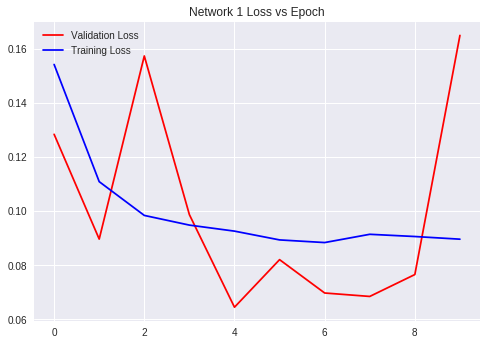

In [14]:
plt.figure("Image")
plt.title("Network 1 Loss vs Epoch")
network_1_valid_loss =  [float(i)/sum(network_1_valid_loss) for i in network_1_valid_loss]
network_1_train_loss =  [float(i)/sum(network_1_train_loss) for i in network_1_train_loss]
plt.plot(network_1_valid_loss, c="red", label="Validation Loss")
plt.plot(network_1_train_loss, c="blue", label = "Training Loss")
plt.legend()
plt.savefig('exp_'+str("Image")+'.png')

In [15]:
net11 = NN1()
net11.load_parameters("N1.params")
net11.collect_params()

nn11_ (
  Parameter nn11_dense0_weight (shape=(512, 784), dtype=float32)
  Parameter nn11_dense0_bias (shape=(512,), dtype=float32)
  Parameter nn11_dense1_weight (shape=(128, 512), dtype=float32)
  Parameter nn11_dense1_bias (shape=(128,), dtype=float32)
  Parameter nn11_dense2_weight (shape=(64, 128), dtype=float32)
  Parameter nn11_dense2_bias (shape=(64,), dtype=float32)
  Parameter nn11_dense3_weight (shape=(32, 64), dtype=float32)
  Parameter nn11_dense3_bias (shape=(32,), dtype=float32)
  Parameter nn11_dense4_weight (shape=(16, 32), dtype=float32)
  Parameter nn11_dense4_bias (shape=(16,), dtype=float32)
  Parameter nn11_dense5_weight (shape=(10, 16), dtype=float32)
  Parameter nn11_dense5_bias (shape=(10,), dtype=float32)
)

In [16]:
cnt = 0
accuracy = 0
for i, (data, label) in enumerate(test_data):
    data , label = transform(data,label)
    data = data.as_in_context(model_ctx).reshape((-1, 784))
    label = label.as_in_context(model_ctx)
    with autograd.record():
        output = net11(data)

        acc = mx.metric.Accuracy()
        acc.update(preds=nd.argmax(output,axis=1),labels=label)
        #print("Test Accuracy : %f"%acc.get()[1])
        accuracy = accuracy + acc.get()[1]
        cnt = cnt + 1

print("Total Accuracy: ", float(accuracy/cnt))

Total Accuracy:  0.852109872611465


In [0]:
net2 = NN2()
net2.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net2.collect_params(), 'adam', {'learning_rate': .01})
epochs = 50
smoothing_constant = .01
patience=3

In [24]:
network_2_train_loss = []
network_2_valid_loss = []
for e in range(epochs):
    cumulative_loss = 0
    now = datetime.now()
    for i, (data, label) in enumerate(train_data):
        data , label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)

        with autograd.record():
            output = net2(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(64)
        cumulative_loss += nd.sum(loss).asscalar()


    val_accuracy, v_loss = evaluate_accuracy(val_data, net2)
    train_accuracy = evaluate_accuracy_train(train_data, net2)
    later = datetime.now()
    difference = (later-now).total_seconds()
    network_2_train_loss.append(cumulative_loss/(num_examples*0.7))
    network_2_valid_loss.append(v_loss/(num_examples*0.3))
    print("Epoch %s. Loss: %s, Train_acc %s, Valid_acc %s, Valid_Loss %s, Time For Epoch(in secs) %s" %(e, cumulative_loss/(num_examples*0.7), train_accuracy, val_accuracy, v_loss/(num_examples*0.3), difference))
    
    net2.save_parameters("N2.params")
    if e>0 and network_2_valid_loss[e]<=np.min([network_2_valid_loss[ep] for ep in np.arange(0,e).tolist()]):
      print("Validation Loss reduced, saving weights....")
      net2.save_parameters("N2.params")
    if e+1>patience and np.sum(np.asarray([network_2_valid_loss[ep + 1] - network_2_valid_loss[ep] for ep in np.arange(e - patience,e).tolist()])>0)==patience:
      break

Epoch 0. Loss: 1.2065944905962263, Train_acc 0.8300238095238095, Valid_acc 0.8267777777777777, Valid_Loss 0.0006133640607198079, Time For Epoch(in secs) 27.006241
Epoch 1. Loss: 0.45906996215525125, Train_acc 0.8555, Valid_acc 0.8503888888888889, Valid_Loss 0.0008170153829786512, Time For Epoch(in secs) 88.101731
Epoch 2. Loss: 0.4181075647104354, Train_acc 0.8356666666666667, Valid_acc 0.8296111111111111, Valid_Loss 0.0004265083736843533, Time For Epoch(in secs) 85.621228
Validation Loss reduced, saving weights....
Epoch 3. Loss: 0.40168156603972116, Train_acc 0.8599285714285714, Valid_acc 0.8523888888888889, Valid_Loss 0.00034722518920898436, Time For Epoch(in secs) 86.946659
Validation Loss reduced, saving weights....
Epoch 4. Loss: 0.38335261028153556, Train_acc 0.8640476190476191, Valid_acc 0.8535555555555555, Valid_Loss 0.00034713782204522027, Time For Epoch(in secs) 87.060823
Validation Loss reduced, saving weights....
Epoch 5. Loss: 0.37776399954160056, Train_acc 0.873785714285

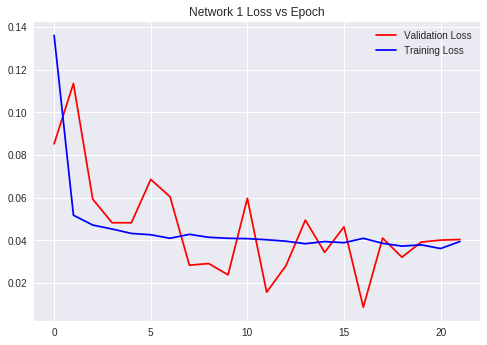

In [28]:
plt.figure("Image")
plt.title("Network 1 Loss vs Epoch")
network_2_valid_loss =  [float(i)/sum(network_2_valid_loss) for i in network_2_valid_loss]
network_2_train_loss =  [float(i)/sum(network_2_train_loss) for i in network_2_train_loss]
plt.plot(network_2_valid_loss, c="red", label="Validation Loss")
plt.plot(network_2_train_loss, c="blue", label = "Training Loss")
plt.legend()
plt.savefig('exp_'+str("Image")+'.png')

In [20]:
net22 = NN2()
net22.load_parameters("N2.params")
net22.collect_params()

nn21_ (
  Parameter nn21_dense0_weight (shape=(1024, 784), dtype=float32)
  Parameter nn21_dense0_bias (shape=(1024,), dtype=float32)
  Parameter nn21_dense1_weight (shape=(512, 1024), dtype=float32)
  Parameter nn21_dense1_bias (shape=(512,), dtype=float32)
  Parameter nn21_dense2_weight (shape=(256, 512), dtype=float32)
  Parameter nn21_dense2_bias (shape=(256,), dtype=float32)
  Parameter nn21_dense3_weight (shape=(10, 256), dtype=float32)
  Parameter nn21_dense3_bias (shape=(10,), dtype=float32)
)

In [21]:
cnt = 0
accuracy = 0
for i, (data, label) in enumerate(test_data):
    data , label = transform(data,label)
    data = data.as_in_context(model_ctx).reshape((-1, 784))
    label = label.as_in_context(model_ctx)
    with autograd.record():
        output = net22(data)

        acc = mx.metric.Accuracy()
        acc.update(preds=nd.argmax(output,axis=1),labels=label)
        #print("Test Accuracy : %f"%acc.get()[1])
        accuracy = accuracy + acc.get()[1]
        cnt = cnt + 1

print("Total Accuracy: ", float(accuracy/cnt))

Total Accuracy:  0.8468351910828026


In [0]:
net3 = NN2()
net3.collect_params().initialize(mx.init.Xavier(rnd_type='uniform', factor_type='avg', magnitude=3), ctx=model_ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net3.collect_params(), 'adam', {'learning_rate': .01})
epochs = 50
smoothing_constant = .01
patience=2

In [27]:
network_3_train_loss = []
network_3_valid_loss = []
for e in range(epochs):
    cumulative_loss = 0
    now = datetime.now()
    for i, (data, label) in enumerate(train_data):
        data , label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)

        with autograd.record():
            output = net3(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(64)
        cumulative_loss += nd.sum(loss).asscalar()


    val_accuracy, v_loss = evaluate_accuracy(val_data, net3)
    train_accuracy = evaluate_accuracy_train(train_data, net3)
    later = datetime.now()
    difference = (later-now).total_seconds()
    network_3_train_loss.append(cumulative_loss/(num_examples*0.7))
    network_3_valid_loss.append(v_loss/(num_examples*0.3))
    print("Epoch %s. Loss: %s, Train_acc %s, Valid_acc %s, Valid_Loss %s, Time For Epoch(in secs) %s" %(e, cumulative_loss/(num_examples*0.7), train_accuracy, val_accuracy, v_loss/(num_examples*0.3), difference))
    
    net3.save_parameters("N3.params")
    if e>0 and network_3_valid_loss[e]<=np.min([network_3_valid_loss[ep] for ep in np.arange(0,e).tolist()]):
      print("Validation Loss reduced, saving weights....")
      net3.save_parameters("N3.params")
    if e+1>patience and np.sum(np.asarray([network_3_valid_loss[ep + 1] - network_3_valid_loss[ep] for ep in np.arange(e - patience,e).tolist()])>0)==patience:
      break

Epoch 0. Loss: 0.6749432341711862, Train_acc 0.833452380952381, Valid_acc 0.8309444444444445, Valid_Loss 0.0007602826754252116, Time For Epoch(in secs) 26.554667
Epoch 1. Loss: 0.48079439703623456, Train_acc 0.8449285714285715, Valid_acc 0.8392222222222222, Valid_Loss 0.0002931942939758301, Time For Epoch(in secs) 91.598277
Validation Loss reduced, saving weights....
Epoch 2. Loss: 0.44183927416233787, Train_acc 0.8536904761904762, Valid_acc 0.8495, Valid_Loss 0.00023496537738376195, Time For Epoch(in secs) 88.170595
Validation Loss reduced, saving weights....
Epoch 3. Loss: 0.41718406404767716, Train_acc 0.8533809523809524, Valid_acc 0.8478333333333333, Valid_Loss 0.0003833543724483914, Time For Epoch(in secs) 87.948102
Epoch 4. Loss: 0.40785560185568676, Train_acc 0.8523095238095239, Valid_acc 0.8472222222222222, Valid_Loss 0.00033438693152533635, Time For Epoch(in secs) 88.707935
Epoch 5. Loss: 0.39779642607484544, Train_acc 0.8569523809523809, Valid_acc 0.8499444444444444, Valid_Lo

In [29]:
net33 = NN2()
net33.load_parameters("N3.params")
net33.collect_params()

nn25_ (
  Parameter nn25_dense0_weight (shape=(1024, 784), dtype=float32)
  Parameter nn25_dense0_bias (shape=(1024,), dtype=float32)
  Parameter nn25_dense1_weight (shape=(512, 1024), dtype=float32)
  Parameter nn25_dense1_bias (shape=(512,), dtype=float32)
  Parameter nn25_dense2_weight (shape=(256, 512), dtype=float32)
  Parameter nn25_dense2_bias (shape=(256,), dtype=float32)
  Parameter nn25_dense3_weight (shape=(10, 256), dtype=float32)
  Parameter nn25_dense3_bias (shape=(10,), dtype=float32)
)

In [30]:
cnt = 0
accuracy = 0
for i, (data, label) in enumerate(test_data):
    data , label = transform(data,label)
    data = data.as_in_context(model_ctx).reshape((-1, 784))
    label = label.as_in_context(model_ctx)
    with autograd.record():
        output = net33(data)

        acc = mx.metric.Accuracy()
        acc.update(preds=nd.argmax(output,axis=1),labels=label)
        #print("Test Accuracy : %f"%acc.get()[1])
        accuracy = accuracy + acc.get()[1]
        cnt = cnt + 1

print("Total Accuracy: ", float(accuracy/cnt))

Total Accuracy:  0.8209593949044586


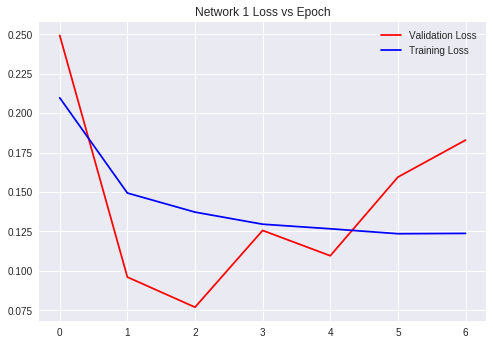

In [31]:
plt.figure("Image")
plt.title("Network 1 Loss vs Epoch")
network_3_valid_loss =  [float(i)/sum(network_3_valid_loss) for i in network_3_valid_loss]
network_3_train_loss =  [float(i)/sum(network_3_train_loss) for i in network_3_train_loss]
plt.plot(network_3_valid_loss, c="red", label="Validation Loss")
plt.plot(network_3_train_loss, c="blue", label = "Training Loss")
plt.legend()
plt.savefig('exp_'+str("Image")+'.png')

In [0]:
net4 = NN2()
net4.collect_params().initialize(mx.init.Orthogonal(scale=1.414, rand_type='uniform'), ctx=model_ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net4.collect_params(), 'adam', {'learning_rate': .01})
epochs = 50
smoothing_constant = .01
patience=2

In [33]:
network_4_train_loss = []
network_4_valid_loss = []
for e in range(epochs):
    cumulative_loss = 0
    now = datetime.now()
    for i, (data, label) in enumerate(train_data):
        data , label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)

        with autograd.record():
            output = net4(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(64)
        cumulative_loss += nd.sum(loss).asscalar()


    val_accuracy, v_loss = evaluate_accuracy(val_data, net4)
    train_accuracy = evaluate_accuracy_train(train_data, net4)
    later = datetime.now()
    difference = (later-now).total_seconds()
    network_4_train_loss.append(cumulative_loss/(num_examples*0.7))
    network_4_valid_loss.append(v_loss/(num_examples*0.3))
    print("Epoch %s. Loss: %s, Train_acc %s, Valid_acc %s, Valid_Loss %s, Time For Epoch(in secs) %s" %(e, cumulative_loss/(num_examples*0.7), train_accuracy, val_accuracy, v_loss/(num_examples*0.3), difference))
    
    net4.save_parameters("N4.params")
    if e>0 and network_4_valid_loss[e]<=np.min([network_4_valid_loss[ep] for ep in np.arange(0,e).tolist()]):
      print("Validation Loss reduced, saving weights....")
      net4.save_parameters("N4.params")
    if e+1>patience and np.sum(np.asarray([network_4_valid_loss[ep + 1] - network_4_valid_loss[ep] for ep in np.arange(e - patience,e).tolist()])>0)==patience:
      break

Epoch 0. Loss: 0.6679745238167899, Train_acc 0.8027380952380953, Valid_acc 0.8021666666666667, Valid_Loss 0.0006075071758694119, Time For Epoch(in secs) 28.319845
Epoch 1. Loss: 0.4633066315991538, Train_acc 0.8574285714285714, Valid_acc 0.8516111111111111, Valid_Loss 0.0005188758638170031, Time For Epoch(in secs) 91.200324
Validation Loss reduced, saving weights....
Epoch 2. Loss: 0.4270957571211315, Train_acc 0.8637619047619047, Valid_acc 0.8554444444444445, Valid_Loss 0.00040245413780212405, Time For Epoch(in secs) 87.08541
Validation Loss reduced, saving weights....
Epoch 3. Loss: 0.4065573130022912, Train_acc 0.864, Valid_acc 0.8579444444444444, Valid_Loss 0.00037681741184658477, Time For Epoch(in secs) 88.553071
Validation Loss reduced, saving weights....
Epoch 4. Loss: 0.40315924217587423, Train_acc 0.8508809523809524, Valid_acc 0.841, Valid_Loss 0.0004891299671596951, Time For Epoch(in secs) 88.955335
Epoch 5. Loss: 0.4077845367590586, Train_acc 0.8737142857142857, Valid_acc 0.

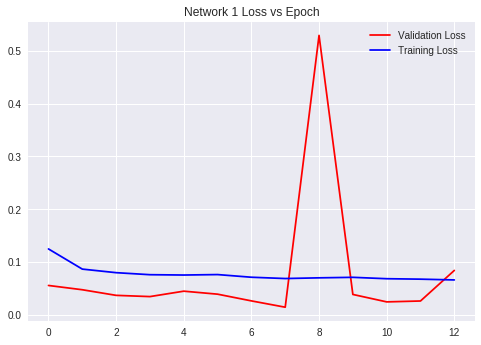

In [34]:
plt.figure("Image")
plt.title("Network 1 Loss vs Epoch")
network_4_valid_loss =  [float(i)/sum(network_4_valid_loss) for i in network_4_valid_loss]
network_4_train_loss =  [float(i)/sum(network_4_train_loss) for i in network_4_train_loss]
plt.plot(network_4_valid_loss, c="red", label="Validation Loss")
plt.plot(network_4_train_loss, c="blue", label = "Training Loss")
plt.legend()
plt.savefig('exp_'+str("Image")+'.png')

In [35]:
net44 = NN2()
net44.load_parameters("N4.params")
net44.collect_params()

nn27_ (
  Parameter nn27_dense0_weight (shape=(1024, 784), dtype=float32)
  Parameter nn27_dense0_bias (shape=(1024,), dtype=float32)
  Parameter nn27_dense1_weight (shape=(512, 1024), dtype=float32)
  Parameter nn27_dense1_bias (shape=(512,), dtype=float32)
  Parameter nn27_dense2_weight (shape=(256, 512), dtype=float32)
  Parameter nn27_dense2_bias (shape=(256,), dtype=float32)
  Parameter nn27_dense3_weight (shape=(10, 256), dtype=float32)
  Parameter nn27_dense3_bias (shape=(10,), dtype=float32)
)

In [36]:
cnt = 0
accuracy = 0
for i, (data, label) in enumerate(test_data):
    data , label = transform(data,label)
    data = data.as_in_context(model_ctx).reshape((-1, 784))
    label = label.as_in_context(model_ctx)
    with autograd.record():
        output = net44(data)

        acc = mx.metric.Accuracy()
        acc.update(preds=nd.argmax(output,axis=1),labels=label)
        #print("Test Accuracy : %f"%acc.get()[1])
        accuracy = accuracy + acc.get()[1]
        cnt = cnt + 1

print("Total Accuracy: ", float(accuracy/cnt))

Total Accuracy:  0.8534036624203821


In [0]:
net5 = gluon.nn.Sequential()
with net5.name_scope():
    ###########################
    # Adding first hidden layer
    ###########################
    net5.add(gluon.nn.Dense(1024, activation="relu"))
    ###########################
    # Adding dropout with rate .5 to the first hidden layer
    ###########################
    net5.add(gluon.nn.Dropout(.1))

    ###########################
    # Adding second hidden layer
    ###########################
    net5.add(gluon.nn.Dense(512, activation="relu"))
    ###########################
    # Adding dropout with rate .5 to the second hidden layer
    ###########################
    net5.add(gluon.nn.Dropout(.4))
    
    net5.add(gluon.nn.Dense(256, activation="relu"))
    ###########################
    # Adding dropout with rate .5 to the second hidden layer
    ###########################
    net5.add(gluon.nn.Dropout(.6))

    ###########################
    # Adding the output layer
    ###########################
    net5.add(gluon.nn.Dense(10))
net5.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net5.collect_params(), 'adam', {'learning_rate': .01})
epochs = 50
smoothing_constant = .01
patience=2

In [40]:
network_5_train_loss = []
network_5_valid_loss = []
for e in range(epochs):
    cumulative_loss = 0
    now = datetime.now()
    for i, (data, label) in enumerate(train_data):
        data , label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)

        with autograd.record():
            output = net5(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(64)
        cumulative_loss += nd.sum(loss).asscalar()


    val_accuracy, v_loss = evaluate_accuracy(val_data, net5)
    train_accuracy = evaluate_accuracy_train(train_data, net5)
    later = datetime.now()
    difference = (later-now).total_seconds()
    network_5_train_loss.append(cumulative_loss/(num_examples*0.7))
    network_5_valid_loss.append(v_loss/(num_examples*0.3))
    print("Epoch %s. Loss: %s, Train_acc %s, Valid_acc %s, Valid_Loss %s, Time For Epoch(in secs) %s" %(e, cumulative_loss/(num_examples*0.7), train_accuracy, val_accuracy, v_loss/(num_examples*0.3), difference))
    
    net5.save_parameters("N5.params")
    if e>0 and network_5_valid_loss[e]<=np.min([network_5_valid_loss[ep] for ep in np.arange(0,e).tolist()]):
      print("Validation Loss reduced, saving weights....")
      net5.save_parameters("N5.params")
    if e+1>patience and np.sum(np.asarray([network_5_valid_loss[ep + 1] - network_5_valid_loss[ep] for ep in np.arange(e - patience,e).tolist()])>0)==patience:
      break

Epoch 0. Loss: 1.2215978977566673, Train_acc 0.7620714285714286, Valid_acc 0.7565, Valid_Loss 0.0007093386650085449, Time For Epoch(in secs) 28.347125
Epoch 1. Loss: 0.8478832375662667, Train_acc 0.7677380952380952, Valid_acc 0.7692222222222223, Valid_Loss 0.0010888307359483507, Time For Epoch(in secs) 77.883295
Epoch 2. Loss: 0.8042680194945563, Train_acc 0.8172142857142857, Valid_acc 0.8155555555555556, Valid_Loss 0.0005671173731486002, Time For Epoch(in secs) 80.777668
Validation Loss reduced, saving weights....
Epoch 3. Loss: 0.8213680183546884, Train_acc 0.8006190476190476, Valid_acc 0.7967222222222222, Valid_Loss 0.000756925106048584, Time For Epoch(in secs) 84.565454
Epoch 4. Loss: 0.7972584731465294, Train_acc 0.785952380952381, Valid_acc 0.7801111111111111, Valid_Loss 0.0004948275883992513, Time For Epoch(in secs) 87.242625
Validation Loss reduced, saving weights....
Epoch 5. Loss: 0.8248588295891172, Train_acc 0.7645, Valid_acc 0.7587777777777778, Valid_Loss 0.000635119438171

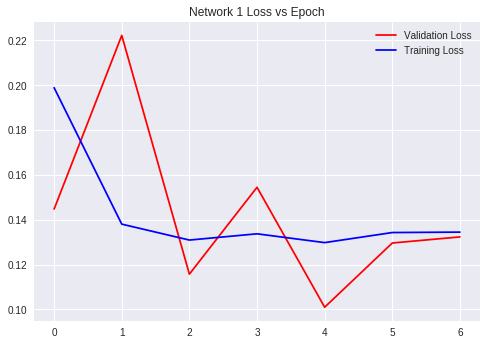

In [41]:
plt.figure("Image")
plt.title("Network 1 Loss vs Epoch")
network_5_valid_loss =  [float(i)/sum(network_5_valid_loss) for i in network_5_valid_loss]
network_5_train_loss =  [float(i)/sum(network_5_train_loss) for i in network_5_train_loss]
plt.plot(network_5_valid_loss, c="red", label="Validation Loss")
plt.plot(network_5_train_loss, c="blue", label = "Training Loss")
plt.legend()
plt.savefig('exp_'+str("Image")+'.png')

In [42]:
cnt = 0
accuracy = 0
for i, (data, label) in enumerate(test_data):
    data , label = transform(data,label)
    data = data.as_in_context(model_ctx).reshape((-1, 784))
    label = label.as_in_context(model_ctx)
    with autograd.record():
        output = net5(data)

        acc = mx.metric.Accuracy()
        acc.update(preds=nd.argmax(output,axis=1),labels=label)
        #print("Test Accuracy : %f"%acc.get()[1])
        accuracy = accuracy + acc.get()[1]
        cnt = cnt + 1

print("Total Accuracy: ", float(accuracy/cnt))

Total Accuracy:  0.6964570063694268


In [0]:
net6 = NN2()
net6.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net6.collect_params(), 'adadelta', {'learning_rate': .01})
epochs = 50
smoothing_constant = .01
patience=2

In [45]:
network_6_train_loss = []
network_6_valid_loss = []
for e in range(epochs):
    cumulative_loss = 0
    now = datetime.now()
    for i, (data, label) in enumerate(train_data):
        data , label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)

        with autograd.record():
            output = net6(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(64)
        cumulative_loss += nd.sum(loss).asscalar()


    val_accuracy, v_loss = evaluate_accuracy(val_data, net6)
    train_accuracy = evaluate_accuracy_train(train_data, net6)
    later = datetime.now()
    difference = (later-now).total_seconds()
    network_6_train_loss.append(cumulative_loss/(num_examples*0.7))
    network_6_valid_loss.append(v_loss/(num_examples*0.3))
    print("Epoch %s. Loss: %s, Train_acc %s, Valid_acc %s, Valid_Loss %s, Time For Epoch(in secs) %s" %(e, cumulative_loss/(num_examples*0.7), train_accuracy, val_accuracy, v_loss/(num_examples*0.3), difference))
    
    net6.save_parameters("N6.params")
    if e>0 and network_6_valid_loss[e]<=np.min([network_6_valid_loss[ep] for ep in np.arange(0,e).tolist()]):
      print("Validation Loss reduced, saving weights....")
      net6.save_parameters("N6.params")
    if e+1>patience and np.sum(np.asarray([network_6_valid_loss[ep + 1] - network_6_valid_loss[ep] for ep in np.arange(e - patience,e).tolist()])>0)==patience:
      break

Epoch 0. Loss: 0.9033530707586379, Train_acc 0.8256190476190476, Valid_acc 0.8216111111111111, Valid_Loss 0.0005207570393880208, Time For Epoch(in secs) 51.203572
Epoch 1. Loss: 0.44611672010875886, Train_acc 0.8459761904761904, Valid_acc 0.8355555555555556, Valid_Loss 0.0008384903801812066, Time For Epoch(in secs) 52.776107
Epoch 2. Loss: 0.3974307930242448, Train_acc 0.881547619047619, Valid_acc 0.8701666666666666, Valid_Loss 0.0003379481103685167, Time For Epoch(in secs) 52.470796
Validation Loss reduced, saving weights....
Epoch 3. Loss: 0.36947926516759966, Train_acc 0.8818095238095238, Valid_acc 0.868, Valid_Loss 0.00034983449512057836, Time For Epoch(in secs) 53.001041
Epoch 4. Loss: 0.34846443218844275, Train_acc 0.8819523809523809, Valid_acc 0.8658333333333333, Valid_Loss 0.0003625146018134223, Time For Epoch(in secs) 52.77062


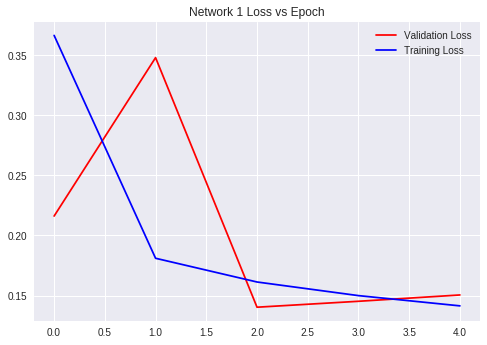

In [46]:
plt.figure("Image")
plt.title("Network 1 Loss vs Epoch")
network_6_valid_loss =  [float(i)/sum(network_6_valid_loss) for i in network_6_valid_loss]
network_6_train_loss =  [float(i)/sum(network_6_train_loss) for i in network_6_train_loss]
plt.plot(network_6_valid_loss, c="red", label="Validation Loss")
plt.plot(network_6_train_loss, c="blue", label = "Training Loss")
plt.legend()
plt.savefig('exp_'+str("Image")+'.png')

In [47]:
net66 = NN2()
net66.load_parameters("N6.params")
net66.collect_params()

nn212_ (
  Parameter nn212_dense0_weight (shape=(1024, 784), dtype=float32)
  Parameter nn212_dense0_bias (shape=(1024,), dtype=float32)
  Parameter nn212_dense1_weight (shape=(512, 1024), dtype=float32)
  Parameter nn212_dense1_bias (shape=(512,), dtype=float32)
  Parameter nn212_dense2_weight (shape=(256, 512), dtype=float32)
  Parameter nn212_dense2_bias (shape=(256,), dtype=float32)
  Parameter nn212_dense3_weight (shape=(10, 256), dtype=float32)
  Parameter nn212_dense3_bias (shape=(10,), dtype=float32)
)

In [48]:
cnt = 0
accuracy = 0
for i, (data, label) in enumerate(test_data):
    data , label = transform(data,label)
    data = data.as_in_context(model_ctx).reshape((-1, 784))
    label = label.as_in_context(model_ctx)
    with autograd.record():
        output = net66(data)

        acc = mx.metric.Accuracy()
        acc.update(preds=nd.argmax(output,axis=1),labels=label)
        #print("Test Accuracy : %f"%acc.get()[1])
        accuracy = accuracy + acc.get()[1]
        cnt = cnt + 1

print("Total Accuracy: ", float(accuracy/cnt))

Total Accuracy:  0.8600716560509554


In [0]:
net7 = NN2()
net7.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net7.collect_params(), 'rmsprop', {'learning_rate': .01})
epochs = 50
smoothing_constant = .01
patience=2

In [50]:
network_7_train_loss = []
network_7_valid_loss = []
for e in range(epochs):
    cumulative_loss = 0
    now = datetime.now()
    for i, (data, label) in enumerate(train_data):
        data , label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)

        with autograd.record():
            output = net7(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(64)
        cumulative_loss += nd.sum(loss).asscalar()


    val_accuracy, v_loss = evaluate_accuracy(val_data, net7)
    train_accuracy = evaluate_accuracy_train(train_data, net7)
    later = datetime.now()
    difference = (later-now).total_seconds()
    network_7_train_loss.append(cumulative_loss/(num_examples*0.7))
    network_7_valid_loss.append(v_loss/(num_examples*0.3))
    print("Epoch %s. Loss: %s, Train_acc %s, Valid_acc %s, Valid_Loss %s, Time For Epoch(in secs) %s" %(e, cumulative_loss/(num_examples*0.7), train_accuracy, val_accuracy, v_loss/(num_examples*0.3), difference))
    
    net7.save_parameters("N7.params")
    if e>0 and network_7_valid_loss[e]<=np.min([network_7_valid_loss[ep] for ep in np.arange(0,e).tolist()]):
      print("Validation Loss reduced, saving weights....")
      net7.save_parameters("N7.params")
    if e+1>patience and np.sum(np.asarray([network_7_valid_loss[ep + 1] - network_7_valid_loss[ep] for ep in np.arange(e - patience,e).tolist()])>0)==patience:
      break

Epoch 0. Loss: 2.950426819596972, Train_acc 0.799047619047619, Valid_acc 0.7954444444444444, Valid_Loss 0.0004079760180579291, Time For Epoch(in secs) 26.765566
Epoch 1. Loss: 0.608735211009071, Train_acc 0.8284761904761905, Valid_acc 0.8213333333333334, Valid_Loss 0.0004014208846622043, Time For Epoch(in secs) 37.2094
Validation Loss reduced, saving weights....
Epoch 2. Loss: 0.553341342931702, Train_acc 0.8045952380952381, Valid_acc 0.8021111111111111, Valid_Loss 0.0004783330493503147, Time For Epoch(in secs) 38.629921
Epoch 3. Loss: 0.536347867937315, Train_acc 0.8435476190476191, Valid_acc 0.8405, Valid_Loss 0.0006239250500996908, Time For Epoch(in secs) 39.047631


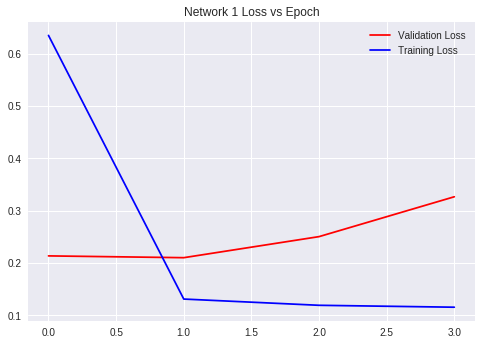

In [51]:
plt.figure("Image")
plt.title("Network 1 Loss vs Epoch")
network_7_valid_loss =  [float(i)/sum(network_7_valid_loss) for i in network_7_valid_loss]
network_7_train_loss =  [float(i)/sum(network_7_train_loss) for i in network_7_train_loss]
plt.plot(network_7_valid_loss, c="red", label="Validation Loss")
plt.plot(network_7_train_loss, c="blue", label = "Training Loss")
plt.legend()
plt.savefig('exp_'+str("Image")+'.png')

In [52]:
net77 = NN2()
net77.load_parameters("N7.params")
net77.collect_params()

nn214_ (
  Parameter nn214_dense0_weight (shape=(1024, 784), dtype=float32)
  Parameter nn214_dense0_bias (shape=(1024,), dtype=float32)
  Parameter nn214_dense1_weight (shape=(512, 1024), dtype=float32)
  Parameter nn214_dense1_bias (shape=(512,), dtype=float32)
  Parameter nn214_dense2_weight (shape=(256, 512), dtype=float32)
  Parameter nn214_dense2_bias (shape=(256,), dtype=float32)
  Parameter nn214_dense3_weight (shape=(10, 256), dtype=float32)
  Parameter nn214_dense3_bias (shape=(10,), dtype=float32)
)

In [53]:
cnt = 0
accuracy = 0
for i, (data, label) in enumerate(test_data):
    data , label = transform(data,label)
    data = data.as_in_context(model_ctx).reshape((-1, 784))
    label = label.as_in_context(model_ctx)
    with autograd.record():
        output = net77(data)

        acc = mx.metric.Accuracy()
        acc.update(preds=nd.argmax(output,axis=1),labels=label)
        #print("Test Accuracy : %f"%acc.get()[1])
        accuracy = accuracy + acc.get()[1]
        cnt = cnt + 1

print("Total Accuracy: ", float(accuracy/cnt))

Total Accuracy:  0.8299164012738853


In [0]:
net8 = NN2()
net8.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net8.collect_params(), 'sgd', {'learning_rate': .01})
epochs = 50
smoothing_constant = .01
patience=2

In [55]:
network_8_train_loss = []
network_8_valid_loss = []
for e in range(epochs):
    cumulative_loss = 0
    now = datetime.now()
    for i, (data, label) in enumerate(train_data):
        data , label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)

        with autograd.record():
            output = net8(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(64)
        cumulative_loss += nd.sum(loss).asscalar()


    val_accuracy, v_loss = evaluate_accuracy(val_data, net8)
    train_accuracy = evaluate_accuracy_train(train_data, net8)
    later = datetime.now()
    difference = (later-now).total_seconds()
    network_8_train_loss.append(cumulative_loss/(num_examples*0.7))
    network_8_valid_loss.append(v_loss/(num_examples*0.3))
    print("Epoch %s. Loss: %s, Train_acc %s, Valid_acc %s, Valid_Loss %s, Time For Epoch(in secs) %s" %(e, cumulative_loss/(num_examples*0.7), train_accuracy, val_accuracy, v_loss/(num_examples*0.3), difference))
    
    net8.save_parameters("N8.params")
    if e>0 and network_8_valid_loss[e]<=np.min([network_8_valid_loss[ep] for ep in np.arange(0,e).tolist()]):
      print("Validation Loss reduced, saving weights....")
      net8.save_parameters("N8.params")
    if e+1>patience and np.sum(np.asarray([network_8_valid_loss[ep + 1] - network_8_valid_loss[ep] for ep in np.arange(e - patience,e).tolist()])>0)==patience:
      break

Epoch 0. Loss: 0.6663208982263292, Train_acc 0.8384047619047619, Valid_acc 0.8304444444444444, Valid_Loss 0.000545207871331109, Time For Epoch(in secs) 18.793307
Epoch 1. Loss: 0.44515503701709563, Train_acc 0.8566666666666667, Valid_acc 0.8483888888888889, Valid_Loss 0.00045469374126858183, Time For Epoch(in secs) 18.845314
Validation Loss reduced, saving weights....
Epoch 2. Loss: 0.39852805307933264, Train_acc 0.8643571428571428, Valid_acc 0.8511666666666666, Valid_Loss 0.00037466467751397025, Time For Epoch(in secs) 18.831866
Validation Loss reduced, saving weights....
Epoch 3. Loss: 0.37000031163011277, Train_acc 0.8801428571428571, Valid_acc 0.8630555555555556, Valid_Loss 0.00025084172354804143, Time For Epoch(in secs) 18.950426
Validation Loss reduced, saving weights....
Epoch 4. Loss: 0.34663139356885636, Train_acc 0.8680238095238095, Valid_acc 0.8485, Valid_Loss 0.00044519752926296656, Time For Epoch(in secs) 18.685091
Epoch 5. Loss: 0.33015984039079577, Train_acc 0.8905, Vali

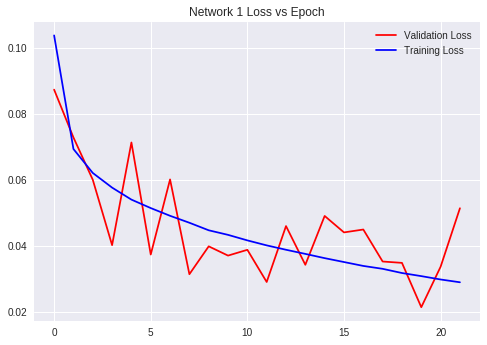

In [56]:
plt.figure("Image")
plt.title("Network 1 Loss vs Epoch")
network_8_valid_loss =  [float(i)/sum(network_8_valid_loss) for i in network_8_valid_loss]
network_8_train_loss =  [float(i)/sum(network_8_train_loss) for i in network_8_train_loss]
plt.plot(network_8_valid_loss, c="red", label="Validation Loss")
plt.plot(network_8_train_loss, c="blue", label = "Training Loss")
plt.legend()
plt.savefig('exp_'+str("Image")+'.png')

In [57]:
net88 = NN2()
net88.load_parameters("N8.params")
net88.collect_params()

nn216_ (
  Parameter nn216_dense0_weight (shape=(1024, 784), dtype=float32)
  Parameter nn216_dense0_bias (shape=(1024,), dtype=float32)
  Parameter nn216_dense1_weight (shape=(512, 1024), dtype=float32)
  Parameter nn216_dense1_bias (shape=(512,), dtype=float32)
  Parameter nn216_dense2_weight (shape=(256, 512), dtype=float32)
  Parameter nn216_dense2_bias (shape=(256,), dtype=float32)
  Parameter nn216_dense3_weight (shape=(10, 256), dtype=float32)
  Parameter nn216_dense3_bias (shape=(10,), dtype=float32)
)

In [58]:
cnt = 0
accuracy = 0
for i, (data, label) in enumerate(test_data):
    data , label = transform(data,label)
    data = data.as_in_context(model_ctx).reshape((-1, 784))
    label = label.as_in_context(model_ctx)
    with autograd.record():
        output = net88(data)

        acc = mx.metric.Accuracy()
        acc.update(preds=nd.argmax(output,axis=1),labels=label)
        #print("Test Accuracy : %f"%acc.get()[1])
        accuracy = accuracy + acc.get()[1]
        cnt = cnt + 1

print("Total Accuracy: ", float(accuracy/cnt))

Total Accuracy:  0.8696257961783439


In [0]:
net9 = NN2()
net9.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(net9.collect_params(), 'nag', {'learning_rate': .01})
epochs = 50
smoothing_constant = .01
patience=2

In [63]:
network_9_train_loss = []
network_9_valid_loss = []
for e in range(epochs):
    cumulative_loss = 0
    now = datetime.now()
    for i, (data, label) in enumerate(train_data):
        data , label = transform(data,label)
        data = data.as_in_context(model_ctx)
        label = label.as_in_context(model_ctx)

        with autograd.record():
            output = net9(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(64)
        cumulative_loss += nd.sum(loss).asscalar()


    val_accuracy, v_loss = evaluate_accuracy(val_data, net9)
    train_accuracy = evaluate_accuracy_train(train_data, net9)
    later = datetime.now()
    difference = (later-now).total_seconds()
    network_9_train_loss.append(cumulative_loss/(num_examples*0.7))
    network_9_valid_loss.append(v_loss/(num_examples*0.3))
    print("Epoch %s. Loss: %s, Train_acc %s, Valid_acc %s, Valid_Loss %s, Time For Epoch(in secs) %s" %(e, cumulative_loss/(num_examples*0.7), train_accuracy, val_accuracy, v_loss/(num_examples*0.3), difference))
    
    net9.save_parameters("N9.params")
    if e>0 and network_9_valid_loss[e]<=np.min([network_9_valid_loss[ep] for ep in np.arange(0,e).tolist()]):
      print("Validation Loss reduced, saving weights....")
      net9.save_parameters("N9.params")
    if e+1>patience and np.sum(np.asarray([network_9_valid_loss[ep + 1] - network_9_valid_loss[ep] for ep in np.arange(e - patience,e).tolist()])>0)==patience:
      break

Epoch 0. Loss: 0.6932864299728757, Train_acc 0.8412380952380952, Valid_acc 0.8312222222222222, Valid_Loss 0.0006880980067782931, Time For Epoch(in secs) 21.825609
Epoch 1. Loss: 0.44392156344368344, Train_acc 0.8637619047619047, Valid_acc 0.8516111111111111, Valid_Loss 0.0004638609886169434, Time For Epoch(in secs) 22.030407
Validation Loss reduced, saving weights....
Epoch 2. Loss: 0.3940790433429536, Train_acc 0.8737380952380952, Valid_acc 0.8540555555555556, Valid_Loss 0.00036760324902004665, Time For Epoch(in secs) 21.918378
Validation Loss reduced, saving weights....
Epoch 3. Loss: 0.3637379693474088, Train_acc 0.8854285714285715, Valid_acc 0.8620555555555556, Valid_Loss 0.00042009774843851724, Time For Epoch(in secs) 22.156444
Epoch 4. Loss: 0.341581150497709, Train_acc 0.8885714285714286, Valid_acc 0.8601666666666666, Valid_Loss 0.00035911247465345594, Time For Epoch(in secs) 22.493254
Validation Loss reduced, saving weights....
Epoch 5. Loss: 0.3224429000218709, Train_acc 0.894

In [64]:
net99 = NN2()
net99.load_parameters("N9.params")
net99.collect_params()

nn221_ (
  Parameter nn221_dense0_weight (shape=(1024, 784), dtype=float32)
  Parameter nn221_dense0_bias (shape=(1024,), dtype=float32)
  Parameter nn221_dense1_weight (shape=(512, 1024), dtype=float32)
  Parameter nn221_dense1_bias (shape=(512,), dtype=float32)
  Parameter nn221_dense2_weight (shape=(256, 512), dtype=float32)
  Parameter nn221_dense2_bias (shape=(256,), dtype=float32)
  Parameter nn221_dense3_weight (shape=(10, 256), dtype=float32)
  Parameter nn221_dense3_bias (shape=(10,), dtype=float32)
)

In [65]:
cnt = 0
accuracy = 0
for i, (data, label) in enumerate(test_data):
    data , label = transform(data,label)
    data = data.as_in_context(model_ctx).reshape((-1, 784))
    label = label.as_in_context(model_ctx)
    with autograd.record():
        output = net99(data)

        acc = mx.metric.Accuracy()
        acc.update(preds=nd.argmax(output,axis=1),labels=label)
        #print("Test Accuracy : %f"%acc.get()[1])
        accuracy = accuracy + acc.get()[1]
        cnt = cnt + 1

print("Total Accuracy: ", float(accuracy/cnt))

Total Accuracy:  0.8672372611464968
